In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
#Unzip onto Google drive for use in Colab
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/Colab Notebooks/lfw'

path = '/content/lfw'

In [3]:
batch_size = 128
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=batch_size, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
#Google Colab uses cuda gpu device, set here
if torch.backends.cuda.is_built():
    device = torch.device("cuda:0")
else:
    print ("Cuda device not found.")
    device = torch.device("cpu")

torch.Size([250, 250, 3])


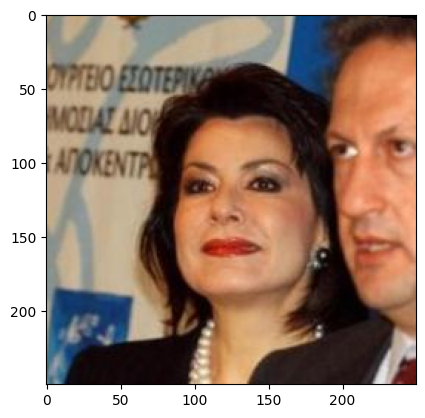

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

## Differences AE vs VAEs

Autoencoders and Variational AutoEncoders differ in a few key ways. They both have models that reduce the dimensionality of the input and rebuild from the lower dimensional space, with an encoder-decoder architecture. but Variational AEs have additional abilities that serve for new data generation.

In applications, AEs learn to reconstruct their inputs, and are good at image compression, and also denoising and anomaly detection. VAEs also reduce dimensions like AEs, but they can be trained to generate new data similar to the input training data by introducing probablistic data points into the latent space. So they can do image synthesis, or make new music or text depeding on the input type, by random inserting similar data as a distribution instead of just one point. Because of this distribution, VAEs also capture more data about the latent representation of the inputs, and can reveal more relationships and learning because of that.

In architecture, both have the encoder-decoder architecture, but an AE encodes single data point. An AE encoder maps the input data to a fixed dimension latent space, and its decoder reconstructs the input from the latent space. In a VAE, the input is mapped to a multivariate normal ( or gaussian, bernoulli, etc. )distribution in the latent space, and the decoder takes samples from the latent distribution and makes new data points. The encoder outputs the parameters for the probablity distribution, as a mean and variance.

Loss function differences between AE and VAE come from the different goals of the model learning. A regular AE just wants to measure the difference between the original input and the reconstructed result and score the similarity. A VAE loss function includes the reconstruction error and a KL(Killback Leibler) divergence term that encourages diverse output using the mean and log variance. The KL regularization term measures how different the distribution learned is to the prior distribution, the approximate posterior learned by the encoder and a chosen prior distribution, generating better data. The KL term ensures that the learned distribution over the latent space is close to the prior distribution, helping with regularization and ensures that the latent space has a continuous structure.VAEs are better for data generation and interpreting the latent space.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        inplace=True
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU (inplace),
            nn.Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU (inplace),
            nn.Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2)),
            nn.ReLU (inplace),
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU (inplace),
            nn.Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1)),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, kernel_size=(4, 4), stride=(1, 1)),
            nn.ReLU (inplace),
            nn.ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU (inplace),
            nn.ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2)),
            nn.ReLU (inplace),
            nn.ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU (inplace),
            nn.ConvTranspose2d(32, 3, kernel_size=(7, 7), stride=(1, 1)),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h.split(h.size(1)//2, 1)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        #From Fleuret VAE
        #std_f = torch.exp(0.5 * logvar_f)
        #z = torch.randn_like(mu_f) * std_f + mu_f
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_() #generate normal distrib random vals
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        out = self.decoder(z)
        return out

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


The encoder outputs a split layer that forms a random normal distribution in the latent space, the decoder expects this size as the latent space. These values are reparametrized using a "reparametrization trick".It works to help by separating the deterministic and randomized parts of the model by sampling from the normal distribution between 0 and 1, instead of the distribution found, by just calculating z=mean+std dev* epsilon, where epsilon is the normal distrib values generated.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [8]:
model = VAE().to(device)

In [9]:
for data in dataloader:
  img,y = data
  #This line puts the variable on the gpu device
  img = img.to(device)

  out_encoder = model.encoder(img)
  print("Shape of latent output of encoder layers: ", out_encoder.shape)

  out_mu, out_logvar = model.encode(img)
  print("Encoder: Shape of encoder mean: ", out_mu.shape)
  print("Encoder: Shape of encoder log variance: ", out_logvar.shape)

  output,mean,logvar = model.forward(img)
  print("Output shape of forward path, same as decoder:",output.size())
  #plt.imshow(output[0].detach().cpu().squeeze().clamp(0, 1).permute(1,2,0))
  #plt.show()
  break

Shape of latent output of encoder layers:  torch.Size([128, 16, 56, 56])
Encoder: Shape of encoder mean:  torch.Size([128, 8, 56, 56])
Encoder: Shape of encoder log variance:  torch.Size([128, 8, 56, 56])
Output shape of forward path, same as decoder: torch.Size([128, 3, 250, 250])


<ipython-input-7-fc8b5b77e24c>:38: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()


### Encoder, latent space, forward
The encoder outputs the mean and log variance values for use in the latent space, which are equally sized, to the chosen dimension of the latent space.

New samples are generated in the latent space (z) by using the resulting encoder values as corresponding to the parameters of a variational random distribution, the mean and log variance (in this case a normal distribution). There is a "reparametrization trick" function in between that implements the sampling of z by generating the random distribution based on the parameters and allows the proper combined size input for the decoder. The decoder takes these randomized distribution and generates different samples that come from the same distribution, and so learns a more continuous output into the input space.

The forward path is verified to work correctly by noting it is outputting the batch size of [3,250,250] images. The decoder is shown below in generating new randomized images after training.

source:
  - https://en.wikipedia.org/wiki/Variational_autoencoder
  - https://fleuret.org/dlc/materials/dlc-handout-7-4-VAE.pdf/
  - https://arxiv.org/pdf/1312.6114.pdf

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [14]:
#Total number of parameters
print("Total number of parameters:", sum(p.numel() for p in model.parameters() ))
print("Total number of learnable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Total number of parameters: 122067
Total number of learnable parameters: 122067


In [11]:
#The optimizer for training, is Adam again, because it is adaptive, easy to use and implement.
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
reconstruction_function = nn.MSELoss(reduction='sum') #)#

def loss_function(x, y,  mu, logvar):
    """
    y: generated images
    x: input images
    mu: latent space mean
    logvar: latent space log variance
    """
    # fit = 0.5 * (output - input).pow(2) #mse
    MSE = reconstruction_function(y, x)  # mse loss like in AE
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2) #KL term
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5) / x.size(0)
    # Total loss is MSE and KL divergence (BCE also possible, but requires more normalized tensors)
    return MSE + KLD

## Loss function
 The loss function used is the sum of the fitting loss and KL divergence loss terms. The fitting loss function is MSE used with a sum reduction, otherwise it would use a mean reduction, which would be smaller values but gave worse results in my testing. The fitting loss works as in an AE taking the input and output image, and minimizing it aims to make the reconstructed image as correct as possible. The KL divergence is a measure of how similar one probability distribution is to another. The KL Divergence term aims to make the distribution in the latent space as close to the normal distribution as it can, so the model can learn to output "correct" but randomized images.

 source:
  - https://fleuret.org/dlc/materials/dlc-handout-7-4-VAE.pdf
  - https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [16]:
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        img, y = data
        img = img.to(device)

        # forward conv VAE
        output, mean, logvar = model(img)
        loss = loss_function(img, output,  mean, logvar)
        #loss = func(output,img)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.data

    # log
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, total_loss))

epoch [1/5], loss:95693744.0000
epoch [2/5], loss:35879944.0000
epoch [3/5], loss:28370886.0000
epoch [4/5], loss:19926014.0000
epoch [5/5], loss:15316575.0000


##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

torch.Size([128, 3, 250, 250])


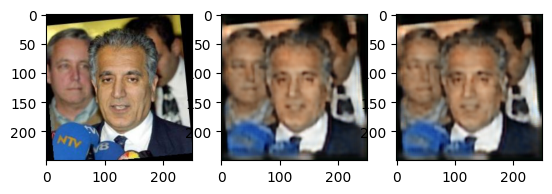

torch.Size([128, 3, 250, 250])


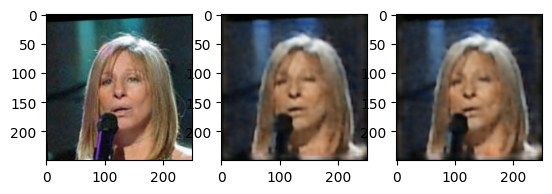

OutOfMemoryError: ignored

In [17]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 250, 250)
    return x
import matplotlib.pyplot as plt
for i, (data) in enumerate(dataloader):
    img, _ = data
    if torch.cuda.is_available():
      img = img.cuda()
    output, _, _ = model(img)
    output = to_img(output.cpu().data)

    output2, _, _ = model(img)
    output2 = to_img(output2.cpu().data)

    img = to_img(img.cpu().data)
    print(output.size())

    plt.subplot(131)
    plt.imshow(img[0].permute(1, 2, 0))
    plt.subplot(132)
    plt.imshow(output[0].permute(1, 2, 0))
    plt.subplot(133)
    plt.imshow(output2[0].permute(1, 2, 0))

    plt.show()
    if i ==3:
      break